In [225]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn import datasets

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV


import seaborn as sns
from sklearn import metrics

from sklearn.model_selection import StratifiedKFold
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Part 1: Regularization

In [226]:
digits= load_digits()
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)

In [227]:
print(x_train)
print(y_train)

[[ 0.  0.  0. ... 16. 16.  6.]
 [ 0.  3. 12. ... 16.  2.  0.]
 [ 0.  1. 10. ...  0.  0.  0.]
 ...
 [ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  4. ...  0.  0.  0.]
 [ 0.  0.  6. ... 11.  0.  0.]]
[6 5 3 ... 7 7 8]


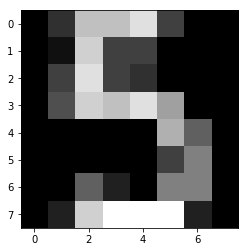

In [228]:
plt.imshow(np.reshape(x_train[1], (8,8)), cmap=plt.cm.gray)
plt.show()
#print(digits.data[100])
#print(digits.target[100])
#print(len(digits.target))

In [229]:
e=np.logspace(-4,4,10)
e

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

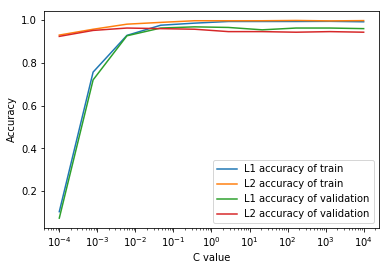

In [230]:
# Set regularization parameter
e=np.logspace(-4,4,10)

acc1_train=[]
acc2_train=[]
acc1_test=[]
acc2_test=[]

for C in e:
    # turn down tolerance for short training time
    l1 = LogisticRegression(C=C, penalty='l1', tol=0.01)
    l2 = LogisticRegression(C=C, penalty='l2', tol=0.01)
    l1.fit(x_train, y_train)
    l2.fit(x_train, y_train)
    acc1_train.append(l1.score(x_train, y_train))
    acc2_train.append(l2.score(x_train, y_train))
    acc1_test.append(l1.score(x_test, y_test))
    acc2_test.append(l2.score(x_test, y_test))

plt.semilogx(e,acc1_train,label='L1 accuracy of train')
plt.semilogx(e,acc2_train,label='L2 accuracy of train')
plt.semilogx(e,acc1_test,label='L1 accuracy of validation')
plt.semilogx(e,acc2_test,label='L2 accuracy of validation')
plt.legend()
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.show()

In [231]:
#Find best C value using GridSearchCV
parameters = {'C' : e}
lg1 = LogisticRegression(C=C,penalty='l1', tol=0.001)
gs1 = GridSearchCV(lg1, parameters,cv=3) 
gs1.fit(x_train, y_train)
C1 = gs1.best_params_['C']

lg1 =LogisticRegression(C=C1,penalty='l1', tol=0.001)
lg1.fit(x_train, y_train)
s1 = lg1.score(x_test, y_test)
print("The best C-value of L1 was", C1, "with an accuracy of", s1)

('The best C-value of L1 was', 0.3593813663804626, 'with an accuracy of', 0.9555555555555556)


In [232]:
parameters = {'C' : e}
lg2 = LogisticRegression(C=C,penalty='l2',  tol=0.001)
gs2 = GridSearchCV(lg2, parameters,cv=3) 
gs2.fit(x_train, y_train)
C2 = gs2.best_params_['C']

lg2 =LogisticRegression(C=C2,penalty='l2',  tol=0.001)
lg2.fit(x_train, y_train)
s2 = lg2.score(x_test, y_test)
print("The best C-value of L2 was", C2, "with an accuracy of", s2)

('The best C-value of L2 was', 0.046415888336127774, 'with an accuracy of', 0.9583333333333334)


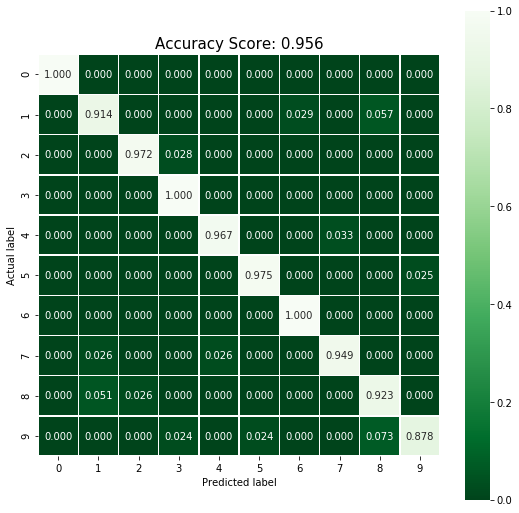

In [233]:
lg1.predict(x_test[0].reshape(1,-1))
lg1_pred = lg1.predict(x_test)
lg1_cm = metrics.confusion_matrix(y_test, lg1_pred)
lg1_cm_normalized = lg1_cm.astype('float') / lg1_cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(lg1_cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Greens_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(s1) 
plt.title(all_sample_title, size = 15);
plt.show()

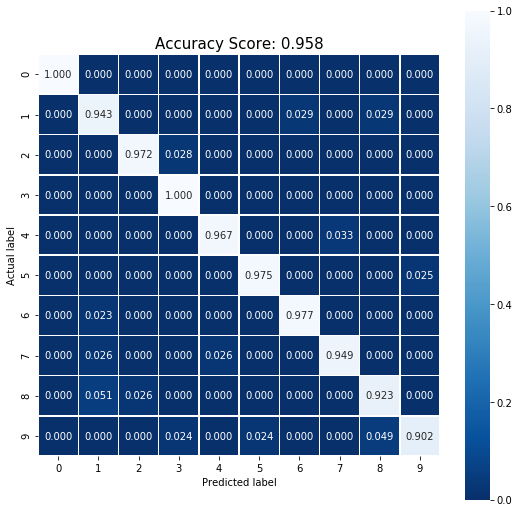

In [234]:
lg2.predict(x_test[0].reshape(1,-1))
lg2_pred = lg2.predict(x_test)
lg2_cm = metrics.confusion_matrix(y_test, lg2_pred)
lg2_cm_normalized = lg2_cm.astype('float') / lg2_cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(lg2_cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(s2) 
plt.title(all_sample_title, size = 15);
plt.show()

# Part 2. Neural Networks

# 1. softmax regression

In [235]:
import tensorflow as tf
tf.__version__

'1.7.0'

In [236]:
# TensorBoard Graph visualizer in notebook
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [237]:
digits.images.shape

(1797, 8, 8)

In [238]:
digits= load_digits()
x_train, x_test, y_train, y_test = train_test_split(digits.data.astype('float32'),
                                                    digits.target.astype('float32'), test_size=0.20, random_state=0)

In [239]:
tf.reset_default_graph()

In [240]:
# Define input
x = tf.placeholder(tf.float32,shape = [None,64]) 
# None, because we don't specify how many examples we'll look at

W = tf.Variable(tf.zeros([64, 10])) # number of weights
b = tf.Variable(tf.zeros([10])) # number of bias terms

In [241]:
y_hat = tf.nn.softmax(tf.matmul(x, W) + b) 
# define what we'll take the softmax activation on

# Notice order on x and W (dimensions must match)
logits=tf.matmul(x, W) + b

In [242]:
# correct answers

y = tf.placeholder(tf.int32, [None])

In [243]:
# Define loss function (that also optimizes Softmax for output):

with tf.name_scope("loss"):
    # logits are from the last output of the dnn
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [244]:
loss

<tf.Tensor 'loss/loss:0' shape=() dtype=float32>

In [245]:
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

In [246]:
# Defining Cost Function
# ce = tf.reduce_mean(-tf.reduce_sum( y* tf.log(y_hat),axis=1))

In [247]:
# ce

In [248]:
#train_step = tf.train.GradientDescentOptimizer(0.001).minimize(ce)

In [249]:
sess = tf.Session()

In [250]:
sess.run(tf.global_variables_initializer())

In [251]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [252]:
correct_prediction = tf.nn.in_top_k(logits,y, 1)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [253]:
a_train=[]
epochs = []
for i in range(200):
    # get batches of training data
    # we don't show everything to the network at once
    batch_xs, batch_ys = next_batch(100,x_train,y_train)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    if i%10==0:
        a_train.append(sess.run(accuracy, feed_dict={x: x_train, y: y_train}))
        epochs.append(i)
        print(i, "Train accuracy:", a_train)

(0, 'Train accuracy:', [0.10229645])
(10, 'Train accuracy:', [0.10229645, 0.78914404])
(20, 'Train accuracy:', [0.10229645, 0.78914404, 0.79749477])
(30, 'Train accuracy:', [0.10229645, 0.78914404, 0.79749477, 0.8803062])
(40, 'Train accuracy:', [0.10229645, 0.78914404, 0.79749477, 0.8803062, 0.89004874])
(50, 'Train accuracy:', [0.10229645, 0.78914404, 0.79749477, 0.8803062, 0.89004874, 0.8761308])
(60, 'Train accuracy:', [0.10229645, 0.78914404, 0.79749477, 0.8803062, 0.89004874, 0.8761308, 0.9130132])
(70, 'Train accuracy:', [0.10229645, 0.78914404, 0.79749477, 0.8803062, 0.89004874, 0.8761308, 0.9130132, 0.91788447])
(80, 'Train accuracy:', [0.10229645, 0.78914404, 0.79749477, 0.8803062, 0.89004874, 0.8761308, 0.9130132, 0.91788447, 0.91858035])
(90, 'Train accuracy:', [0.10229645, 0.78914404, 0.79749477, 0.8803062, 0.89004874, 0.8761308, 0.9130132, 0.91788447, 0.91858035, 0.91858035])
(100, 'Train accuracy:', [0.10229645, 0.78914404, 0.79749477, 0.8803062, 0.89004874, 0.8761308, 0

In [254]:
a_test=[]
for i in range(200):
    # get batches of training data
    # we don't show everything to the network at once
    batch_xs, batch_ys = next_batch(100,x_train,y_train)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    if i%10==0:
        a_test.append(sess.run(accuracy, feed_dict={x: x_test, y: y_test})) 
        print(i, "Test accuracy:", a_test)

(0, 'Test accuracy:', [0.9388889])
(10, 'Test accuracy:', [0.9388889, 0.9361111])
(20, 'Test accuracy:', [0.9388889, 0.9361111, 0.9305556])
(30, 'Test accuracy:', [0.9388889, 0.9361111, 0.9305556, 0.9361111])
(40, 'Test accuracy:', [0.9388889, 0.9361111, 0.9305556, 0.9361111, 0.93333334])
(50, 'Test accuracy:', [0.9388889, 0.9361111, 0.9305556, 0.9361111, 0.93333334, 0.9305556])
(60, 'Test accuracy:', [0.9388889, 0.9361111, 0.9305556, 0.9361111, 0.93333334, 0.9305556, 0.9388889])
(70, 'Test accuracy:', [0.9388889, 0.9361111, 0.9305556, 0.9361111, 0.93333334, 0.9305556, 0.9388889, 0.9388889])
(80, 'Test accuracy:', [0.9388889, 0.9361111, 0.9305556, 0.9361111, 0.93333334, 0.9305556, 0.9388889, 0.9388889, 0.9444444])
(90, 'Test accuracy:', [0.9388889, 0.9361111, 0.9305556, 0.9361111, 0.93333334, 0.9305556, 0.9388889, 0.9388889, 0.9444444, 0.94166666])
(100, 'Test accuracy:', [0.9388889, 0.9361111, 0.9305556, 0.9361111, 0.93333334, 0.9305556, 0.9388889, 0.9388889, 0.9444444, 0.94166666, 0.

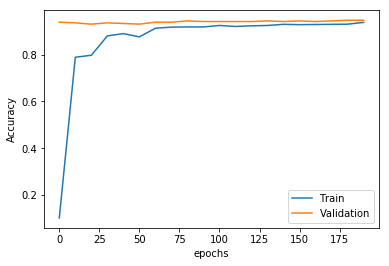

In [255]:
plt.plot(epochs, a_train, label="Train")
plt.plot(epochs, a_test, label="Validation")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

In [32]:
show_graph(tf.get_default_graph()) #not that great, we should probably use scopes

# 2.Dense Neural Network 

In [89]:
digits= load_digits()
x_train, x_test, y_train, y_test = train_test_split(digits.data,digits.target, test_size=0.20, random_state=0)

In [90]:
# Define hyperparameters and input size

n_inputs = 8*8  # DIGITS
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = 10

In [92]:
# Reset graph
tf.reset_default_graph()

In [93]:
# Placeholders for data (inputs and targets)
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [129]:
# Define neuron layers (ReLU in hidden layers)
# We'll take care of Softmax for output with loss function

def neuron_layer(X, n_neurons, name, activation=None):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function
    
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        scale = tf.Variable(tf.ones([n_neurons]))
        beta = tf.Variable(tf.zeros([n_neurons]))
        # Output from every neuron
        Z = tf.matmul(X, W) + b       
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [130]:
# Define the hidden layers
keep_prob = 0.9
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.tanh)
    drop_out1 = tf.nn.dropout(hidden1, keep_prob)
    
    hidden2 = neuron_layer(drop_out1, n_hidden2, name="hidden2",
                           activation=tf.nn.tanh)
    drop_out2 = tf.nn.dropout(hidden2, keep_prob)
    
    hidden3 = neuron_layer(drop_out2, n_hidden3, name="hidden3",
                           activation=tf.nn.tanh)
    drop_out3 = tf.nn.dropout(hidden3, keep_prob)
    
    logits = neuron_layer(drop_out3, n_outputs, name="outputs")

In [131]:
# Define loss function (that also optimizes Softmax for output):

with tf.name_scope("loss"):
    # logits are from the last output of the dnn
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [132]:
# Training step with Gradient Descent

learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [133]:
# Evaluation to see accuracy

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [134]:
show_graph(tf.get_default_graph())

In [135]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 1000
batch_size = 100

epoch1 = []
acc_train1 = []
acc_val1 = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for i in range(len(x_train) // batch_size):
            batch_xs, batch_ys = next_batch(100,x_train,y_train)
            sess.run(training_op, feed_dict={X: batch_xs, y:batch_ys})
        acc_train = accuracy.eval(feed_dict={X: batch_xs, y:batch_ys})
        acc_val = accuracy.eval(feed_dict={X: x_test, y:y_test})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)
        epoch1.append(epoch)
        acc_train1.append(acc_train)
        acc_val1.append(acc_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt") # save model

(0, 'Train accuracy:', 0.08, 'Val accuracy:', 0.12222222)
(1, 'Train accuracy:', 0.13, 'Val accuracy:', 0.07777778)
(2, 'Train accuracy:', 0.1, 'Val accuracy:', 0.11388889)
(3, 'Train accuracy:', 0.16, 'Val accuracy:', 0.119444445)
(4, 'Train accuracy:', 0.1, 'Val accuracy:', 0.12777779)
(5, 'Train accuracy:', 0.16, 'Val accuracy:', 0.15277778)
(6, 'Train accuracy:', 0.15, 'Val accuracy:', 0.15)
(7, 'Train accuracy:', 0.24, 'Val accuracy:', 0.18611111)
(8, 'Train accuracy:', 0.24, 'Val accuracy:', 0.18888889)
(9, 'Train accuracy:', 0.25, 'Val accuracy:', 0.23055555)
(10, 'Train accuracy:', 0.28, 'Val accuracy:', 0.20277777)
(11, 'Train accuracy:', 0.31, 'Val accuracy:', 0.22777778)
(12, 'Train accuracy:', 0.25, 'Val accuracy:', 0.275)
(13, 'Train accuracy:', 0.36, 'Val accuracy:', 0.29166666)
(14, 'Train accuracy:', 0.3, 'Val accuracy:', 0.29166666)
(15, 'Train accuracy:', 0.38, 'Val accuracy:', 0.35)
(16, 'Train accuracy:', 0.42, 'Val accuracy:', 0.325)
(17, 'Train accuracy:', 0.37, '

(142, 'Train accuracy:', 0.9, 'Val accuracy:', 0.82222223)
(143, 'Train accuracy:', 0.87, 'Val accuracy:', 0.81666666)
(144, 'Train accuracy:', 0.88, 'Val accuracy:', 0.84166664)
(145, 'Train accuracy:', 0.94, 'Val accuracy:', 0.8472222)
(146, 'Train accuracy:', 0.9, 'Val accuracy:', 0.85)
(147, 'Train accuracy:', 0.88, 'Val accuracy:', 0.80277777)
(148, 'Train accuracy:', 0.92, 'Val accuracy:', 0.8611111)
(149, 'Train accuracy:', 0.86, 'Val accuracy:', 0.85)
(150, 'Train accuracy:', 0.9, 'Val accuracy:', 0.83055556)
(151, 'Train accuracy:', 0.87, 'Val accuracy:', 0.8277778)
(152, 'Train accuracy:', 0.94, 'Val accuracy:', 0.875)
(153, 'Train accuracy:', 0.88, 'Val accuracy:', 0.8333333)
(154, 'Train accuracy:', 0.9, 'Val accuracy:', 0.8527778)
(155, 'Train accuracy:', 0.97, 'Val accuracy:', 0.8611111)
(156, 'Train accuracy:', 0.87, 'Val accuracy:', 0.85555553)
(157, 'Train accuracy:', 0.86, 'Val accuracy:', 0.8361111)
(158, 'Train accuracy:', 0.94, 'Val accuracy:', 0.8666667)
(159, 'Tr

(283, 'Train accuracy:', 0.96, 'Val accuracy:', 0.9166667)
(284, 'Train accuracy:', 0.95, 'Val accuracy:', 0.9222222)
(285, 'Train accuracy:', 0.97, 'Val accuracy:', 0.85833335)
(286, 'Train accuracy:', 0.96, 'Val accuracy:', 0.8888889)
(287, 'Train accuracy:', 0.96, 'Val accuracy:', 0.87222224)
(288, 'Train accuracy:', 0.93, 'Val accuracy:', 0.88055557)
(289, 'Train accuracy:', 0.95, 'Val accuracy:', 0.8833333)
(290, 'Train accuracy:', 0.93, 'Val accuracy:', 0.8833333)
(291, 'Train accuracy:', 0.92, 'Val accuracy:', 0.8972222)
(292, 'Train accuracy:', 0.97, 'Val accuracy:', 0.9027778)
(293, 'Train accuracy:', 0.98, 'Val accuracy:', 0.9027778)
(294, 'Train accuracy:', 0.96, 'Val accuracy:', 0.8972222)
(295, 'Train accuracy:', 0.98, 'Val accuracy:', 0.8972222)
(296, 'Train accuracy:', 0.92, 'Val accuracy:', 0.8888889)
(297, 'Train accuracy:', 0.94, 'Val accuracy:', 0.8972222)
(298, 'Train accuracy:', 0.93, 'Val accuracy:', 0.9)
(299, 'Train accuracy:', 0.91, 'Val accuracy:', 0.8833333)


(424, 'Train accuracy:', 0.94, 'Val accuracy:', 0.93333334)
(425, 'Train accuracy:', 0.94, 'Val accuracy:', 0.91944444)
(426, 'Train accuracy:', 0.98, 'Val accuracy:', 0.9222222)
(427, 'Train accuracy:', 0.95, 'Val accuracy:', 0.90555555)
(428, 'Train accuracy:', 0.97, 'Val accuracy:', 0.925)
(429, 'Train accuracy:', 0.96, 'Val accuracy:', 0.90833336)
(430, 'Train accuracy:', 0.95, 'Val accuracy:', 0.9111111)
(431, 'Train accuracy:', 0.97, 'Val accuracy:', 0.90555555)
(432, 'Train accuracy:', 0.98, 'Val accuracy:', 0.925)
(433, 'Train accuracy:', 0.95, 'Val accuracy:', 0.9111111)
(434, 'Train accuracy:', 0.93, 'Val accuracy:', 0.9222222)
(435, 'Train accuracy:', 0.98, 'Val accuracy:', 0.90833336)
(436, 'Train accuracy:', 0.99, 'Val accuracy:', 0.92777777)
(437, 'Train accuracy:', 0.98, 'Val accuracy:', 0.9305556)
(438, 'Train accuracy:', 0.99, 'Val accuracy:', 0.90833336)
(439, 'Train accuracy:', 0.96, 'Val accuracy:', 0.91944444)
(440, 'Train accuracy:', 0.96, 'Val accuracy:', 0.90555

(566, 'Train accuracy:', 0.99, 'Val accuracy:', 0.9222222)
(567, 'Train accuracy:', 0.98, 'Val accuracy:', 0.9138889)
(568, 'Train accuracy:', 0.94, 'Val accuracy:', 0.925)
(569, 'Train accuracy:', 0.94, 'Val accuracy:', 0.90555555)
(570, 'Train accuracy:', 1.0, 'Val accuracy:', 0.9027778)
(571, 'Train accuracy:', 0.99, 'Val accuracy:', 0.9222222)
(572, 'Train accuracy:', 0.98, 'Val accuracy:', 0.91944444)
(573, 'Train accuracy:', 0.97, 'Val accuracy:', 0.92777777)
(574, 'Train accuracy:', 0.96, 'Val accuracy:', 0.90833336)
(575, 'Train accuracy:', 0.98, 'Val accuracy:', 0.9138889)
(576, 'Train accuracy:', 0.97, 'Val accuracy:', 0.9305556)
(577, 'Train accuracy:', 0.99, 'Val accuracy:', 0.9305556)
(578, 'Train accuracy:', 0.97, 'Val accuracy:', 0.9305556)
(579, 'Train accuracy:', 0.96, 'Val accuracy:', 0.9305556)
(580, 'Train accuracy:', 0.98, 'Val accuracy:', 0.9361111)
(581, 'Train accuracy:', 0.97, 'Val accuracy:', 0.9305556)
(582, 'Train accuracy:', 0.97, 'Val accuracy:', 0.925)
(5

(707, 'Train accuracy:', 0.97, 'Val accuracy:', 0.93333334)
(708, 'Train accuracy:', 0.98, 'Val accuracy:', 0.94166666)
(709, 'Train accuracy:', 0.97, 'Val accuracy:', 0.93333334)
(710, 'Train accuracy:', 0.99, 'Val accuracy:', 0.91944444)
(711, 'Train accuracy:', 0.96, 'Val accuracy:', 0.9305556)
(712, 'Train accuracy:', 0.99, 'Val accuracy:', 0.94166666)
(713, 'Train accuracy:', 0.97, 'Val accuracy:', 0.94722223)
(714, 'Train accuracy:', 0.99, 'Val accuracy:', 0.94166666)
(715, 'Train accuracy:', 0.97, 'Val accuracy:', 0.92777777)
(716, 'Train accuracy:', 0.96, 'Val accuracy:', 0.9444444)
(717, 'Train accuracy:', 0.99, 'Val accuracy:', 0.91944444)
(718, 'Train accuracy:', 0.99, 'Val accuracy:', 0.925)
(719, 'Train accuracy:', 0.98, 'Val accuracy:', 0.9222222)
(720, 'Train accuracy:', 0.99, 'Val accuracy:', 0.9361111)
(721, 'Train accuracy:', 0.98, 'Val accuracy:', 0.9111111)
(722, 'Train accuracy:', 0.98, 'Val accuracy:', 0.9444444)
(723, 'Train accuracy:', 0.99, 'Val accuracy:', 0.9

(847, 'Train accuracy:', 0.98, 'Val accuracy:', 0.95)
(848, 'Train accuracy:', 0.99, 'Val accuracy:', 0.925)
(849, 'Train accuracy:', 1.0, 'Val accuracy:', 0.9444444)
(850, 'Train accuracy:', 0.97, 'Val accuracy:', 0.94166666)
(851, 'Train accuracy:', 1.0, 'Val accuracy:', 0.9361111)
(852, 'Train accuracy:', 0.99, 'Val accuracy:', 0.9527778)
(853, 'Train accuracy:', 0.99, 'Val accuracy:', 0.93333334)
(854, 'Train accuracy:', 0.96, 'Val accuracy:', 0.9444444)
(855, 'Train accuracy:', 0.99, 'Val accuracy:', 0.9444444)
(856, 'Train accuracy:', 0.97, 'Val accuracy:', 0.93333334)
(857, 'Train accuracy:', 0.97, 'Val accuracy:', 0.95)
(858, 'Train accuracy:', 0.98, 'Val accuracy:', 0.9305556)
(859, 'Train accuracy:', 0.98, 'Val accuracy:', 0.9388889)
(860, 'Train accuracy:', 1.0, 'Val accuracy:', 0.94166666)
(861, 'Train accuracy:', 0.95, 'Val accuracy:', 0.92777777)
(862, 'Train accuracy:', 1.0, 'Val accuracy:', 0.93333334)
(863, 'Train accuracy:', 0.97, 'Val accuracy:', 0.94166666)
(864, 'T

(990, 'Train accuracy:', 0.99, 'Val accuracy:', 0.9527778)
(991, 'Train accuracy:', 1.0, 'Val accuracy:', 0.925)
(992, 'Train accuracy:', 0.96, 'Val accuracy:', 0.95)
(993, 'Train accuracy:', 1.0, 'Val accuracy:', 0.9361111)
(994, 'Train accuracy:', 0.99, 'Val accuracy:', 0.94722223)
(995, 'Train accuracy:', 0.99, 'Val accuracy:', 0.9388889)
(996, 'Train accuracy:', 0.98, 'Val accuracy:', 0.93333334)
(997, 'Train accuracy:', 0.99, 'Val accuracy:', 0.94722223)
(998, 'Train accuracy:', 1.0, 'Val accuracy:', 0.94722223)
(999, 'Train accuracy:', 0.99, 'Val accuracy:', 0.95555556)


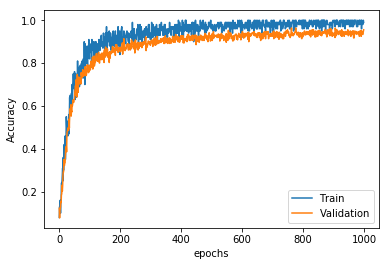

In [136]:
plt.plot(epoch1, acc_train1, label="Train")
plt.plot(epoch1, acc_val1, label="Validation")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

# Part 3: Extra Credit 

Nowadays it is more common to use the ReLU (Rectified Linear Unit). Much quicker! For deep networks sigmoid might not want to converge at all. Much better to handle exploding and vanishing gradients (Leaky Relu). Can also combat that with Batch Normalization.

In [137]:
digits= load_digits()
x_train, x_test, y_train, y_test = train_test_split(digits.data,digits.target, test_size=0.20, random_state=0)

In [138]:
# Define hyperparameters and input size

n_inputs = 8*8  # DIGITS
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = 10

In [139]:
# Reset graph
tf.reset_default_graph()

In [140]:
# Placeholders for data (inputs and targets)
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [155]:
# Define neuron layers (ReLU in hidden layers)
# We'll take care of Softmax for output with loss function

epsilon = 1e-3

def neuron_layer(X, n_neurons, name, activation=None):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function
    
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        # Output from every neuron
        Z = tf.matmul(X, W) + b
        batch_mean, batch_var = tf.nn.moments(Z,[0])
        scale = tf.Variable(tf.ones([n_neurons]))
        beta = tf.Variable(tf.zeros([n_neurons]))
        BN = tf.nn.batch_normalization(Z,batch_mean,batch_var,beta,scale,epsilon)
        
        if activation is not None:
            return activation(BN)
        else:
            return BN

In [156]:
# Define the hidden layers
keep_prob = 0.9
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.tanh)
    drop_out1 = tf.nn.dropout(hidden1, keep_prob)
    
    hidden2 = neuron_layer(drop_out1, n_hidden2, name="hidden2",
                           activation=tf.nn.tanh)
    drop_out2 = tf.nn.dropout(hidden2, keep_prob)
    
    hidden3 = neuron_layer(drop_out2, n_hidden3, name="hidden3",
                           activation=tf.nn.tanh)
    drop_out3 = tf.nn.dropout(hidden3, keep_prob)
    
    logits = neuron_layer(drop_out3, n_outputs, name="outputs")

In [207]:
# Define loss function (that also optimizes Softmax for output):

with tf.name_scope("loss"):
    # logits are from the last output of the dnn
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")


In [158]:
# Training step with Gradient Descent

learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [159]:
# Evaluation to see accuracy

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [171]:
show_graph(tf.get_default_graph())

In [213]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 1000
batch_size = 100

epoch2 = []
acc_train2 = []
acc_val2 = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for i in range(len(x_train) // batch_size):
            batch_xs, batch_ys = next_batch(100,x_train,y_train)
            sess.run(training_op, feed_dict={X: batch_xs, y:batch_ys})
            
        if epoch % 50 is 0:
            acc_train=accuracy.eval(feed_dict={X: batch_xs, y:batch_ys})
            acc_val = accuracy.eval(feed_dict={X: x_test, y:y_test})
            print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)
            epoch2.append(epoch)
            acc_train2.append(acc_train)
            acc_val2.append(acc_val)
            
    save_path = saver.save(sess, "./my_model_final.ckpt") # save model

(0, 'Train accuracy:', 0.06, 'Val accuracy:', 0.06666667)
(50, 'Train accuracy:', 0.66, 'Val accuracy:', 0.7083333)
(100, 'Train accuracy:', 0.76, 'Val accuracy:', 0.8361111)
(150, 'Train accuracy:', 0.92, 'Val accuracy:', 0.85833335)
(200, 'Train accuracy:', 0.9, 'Val accuracy:', 0.9138889)
(250, 'Train accuracy:', 0.85, 'Val accuracy:', 0.90833336)
(300, 'Train accuracy:', 0.93, 'Val accuracy:', 0.94166666)
(350, 'Train accuracy:', 0.94, 'Val accuracy:', 0.9138889)
(400, 'Train accuracy:', 0.95, 'Val accuracy:', 0.9166667)
(450, 'Train accuracy:', 0.92, 'Val accuracy:', 0.9138889)
(500, 'Train accuracy:', 0.89, 'Val accuracy:', 0.9111111)
(550, 'Train accuracy:', 0.94, 'Val accuracy:', 0.925)
(600, 'Train accuracy:', 0.95, 'Val accuracy:', 0.9305556)
(650, 'Train accuracy:', 0.95, 'Val accuracy:', 0.9444444)
(700, 'Train accuracy:', 0.97, 'Val accuracy:', 0.9361111)
(750, 'Train accuracy:', 0.96, 'Val accuracy:', 0.9388889)
(800, 'Train accuracy:', 0.92, 'Val accuracy:', 0.9444444)
(

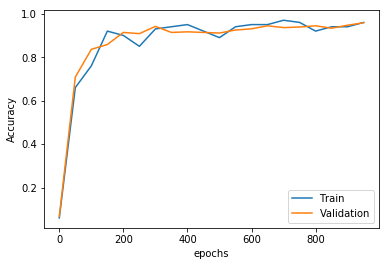

In [214]:
plt.plot(epoch2, acc_train2, label="Train")
plt.plot(epoch2, acc_val2, label="Validation")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()